In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import tensorflow as tf

In [19]:
np.random.seed(10)
tf.compat.v1.set_random_seed(10)

In [20]:
df_koi = pd.read_csv("./mast-info.csv", skiprows=53)

# Cargo los csv
df_local = pd.read_csv("./unified-lightcurves-local.csv").iloc[:, 1:]
df_global = pd.read_csv("./unified-lightcurves-global.csv").iloc[:, 1:]

local_fluxes = df_local.iloc[:,4:]
local_labels = df_local.iloc[:,3]

global_fluxes = df_global.iloc[:,4:]
global_labels = df_global.iloc[:,3]

In [21]:
def getModel():
    inputLocalView = tf.keras.layers.Input(shape=(n_local_features, 1))
    inputLocalView.set_shape([n_local_timesteps, n_local_features, 1]) # 4266 x 101

    CL1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(inputLocalView)
    CL2 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(CL1)

    ML1 = tf.keras.layers.MaxPooling1D(pool_size=7, strides=2)(CL2)

    CL3 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(ML1)
    CL4 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(CL3)

    ML2 = tf.keras.layers.MaxPooling1D(pool_size=7, strides=2)(CL4)

    flat1 = tf.keras.layers.Flatten()(ML2)

    inputGlobalView = tf.keras.layers.Input(shape=(n_global_features, 1))
    inputGlobalView.set_shape([n_global_timesteps, n_global_features, 1])  # 4266 x 1001


    CG1 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(inputGlobalView)
    CG2 = tf.keras.layers.Conv1D(filters=16, kernel_size=5, activation='relu')(CG1)

    MG1 = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(CG2)

    CG3 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(MG1)
    CG4 = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu')(CG3)

    MG2 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG4)

    CG5 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(MG2)
    CG6 = tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu')(CG5)

    MG3 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG6)

    CG7 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(MG3)
    CG8 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(CG7)

    MG4 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG8)

    CG9 = tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu')(MG4)
    CG10 = tf.keras.layers.Conv1D(filters=256, kernel_size=5, activation='relu')(CG9)

    MG5 = tf.keras.layers.MaxPooling1D(pool_size=2, strides=2)(CG10)

    flat2 = tf.keras.layers.Flatten()(MG5)

    # merge input models
    merge = tf.keras.layers.concatenate([flat1, flat2])

    # interpretation model
    hidden1 = tf.keras.layers.Dense(256, activation='relu')(merge)
    hidden2 = tf.keras.layers.Dense(256, activation='relu')(hidden1)
    hidden3 = tf.keras.layers.Dense(256, activation='relu')(hidden2)
    hidden4 = tf.keras.layers.Dense(256, activation='relu')(hidden3)

    output = tf.keras.layers.Dense(n_outputs, activation=output_activation)(hidden4)

    model = tf.keras.Model(inputs=[inputLocalView,inputGlobalView], outputs=output)

    model.compile(loss='binary_crossentropy', optimizer=output_optimizer, metrics=['accuracy'])

    return model

In [22]:
test_percent = 0.1
n_outputs = 1
n_models = 10
output_activation = 'tanh' # tanh / sigmoid / relu #
output_optimizer = 'adamax' # adam / adamax #

models = list()

for step in range(n_models):
    print("Step", step)

    rrnn = 'gobal-and-local-modelavg-' + str(step)

    basefolder = "trainings/" + rrnn + "_" + output_activation + "-" + output_optimizer 
    basepath = basefolder + "/" + rrnn + "_" + output_activation + "-" + output_optimizer


    x_local_train, x_local_test, y_local_train, y_local_test = train_test_split(
        local_fluxes, local_labels, test_size=test_percent, random_state=step)
        
    x_global_train, x_global_test, y_global_train, y_global_test = train_test_split(
        global_fluxes, global_labels, test_size=test_percent, random_state=step)

    n_local_timesteps, n_local_features  = x_local_train.shape[0], x_local_train.shape[1]
    n_global_timesteps, n_global_features  = x_global_train.shape[0], x_global_train.shape[1]


    x_local_extended_train = np.expand_dims(x_local_train,axis=-1) 
    y_local_extended_train = np.array(y_local_train)

    x_global_extended_train = np.expand_dims(x_global_train,axis=-1)
    y_global_extended_train = np.array(y_global_train)

    x_local_extended_test = np.expand_dims(x_local_test,axis=-1)
    y_local_extended_test = np.array(y_local_test)

    x_global_extended_test = np.expand_dims(x_global_test,axis=-1)
    y_global_extended_test = np.array(y_global_test)

    print("-> get model")

    model = getModel()

    # Establecemos callbacks para guardad los pasos
    checkpoint_path = basepath + "-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path, 
        verbose=0, 
        save_weights_only=True,
        save_freq='epoch'
    )

    os.makedirs(checkpoint_dir, exist_ok=True)


    print("-> fit model")

    latest = tf.train.latest_checkpoint(basefolder)

    if latest: #force else
        print("-> load prefitted")
        model.load_weights(latest)
    else :
        bs = 1097
        model.fit(
            [x_local_extended_train, x_global_extended_train], 
            y_local_extended_train, 
            epochs=50, 
            batch_size=bs,
            
            callbacks=[cp_callback],

        )

        model.save(basepath + ".h5")

    print("-> done")
    models.append(model)


 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 22/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 23/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 24/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 25/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 26/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 27/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 28/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 29/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 30/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accuracy: 0.7521
Epoch 31/50
5/5 [==============================] - 14s 3s/step - loss: 3.8246 - accu

In [63]:
def pintar_matriz_confusion(conf_matx):
    df_cm = pd.DataFrame(conf_matx, index = [i for i in "01"],
                    columns = [i for i in "01"])

    plt.figure(0.5)
    heat_map = sn.heatmap(df_cm, xticklabels=True, yticklabels=True, annot=True, annot_kws = {"ha": 'center'})
    #heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
    plt.xlabel('Predicción')
    plt.ylabel('Real')


def pintar_roc_curve(fp,tp, optimizer, activation):
    area_under_curve = auc(fp,tp)
    gmeans = np.sqrt(tp * (1-fp))
    ix = np.argmax(gmeans)

    
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(
        fp, 
        tp, 
        label=optimizer + ' #' + activation + ' (auc = {:.3f})'.format(area_under_curve)
    )
    plt.scatter(fp[ix], tp[ix], marker='x', color='black')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')

    plt.legend( title='10 tests for adamax + tanh\n', 
                bbox_to_anchor=(1.05, 1), 
                loc='upper left'
    )


list_accuracy: 	 [0.819672131147541, 0.8344262295081967, 0.719672131147541, 0.739344262295082, 0.7295081967213115, 0.8344262295081967, 0.7704918032786885, 0.8327868852459016, 0.8442622950819673, 0.839344262295082]
avg_accuracy: 	 0.7963934426229509



list_average_precision: 	 [0.4588434412348088, 0.502692062140881, 0.28032786885245903, 0.260655737704918, 0.27049180327868855, 0.47252132720053464, 0.22950819672131148, 0.4843806921675774, 0.4688193409504885, 0.5111275310704386]
avg_average_precision: 	 0.3939368001322106



list_recall: 	 [array([0.92624729, 0.48993289]), array([0.91341991, 0.58783784]), array([1., 0.]), array([1., 0.]), array([1., 0.]), array([0.91295117, 0.56834532]), array([1., 0.]), array([0.91416309, 0.56944444]), array([0.92259414, 0.56060606]), array([0.95633188, 0.48684211])]
avg_recall: 	 0.640435806878369



list_f1: 	 [0.5703125, 0.6327272727272727, 0.0, 0.0, 0.0, 0.61003861003861, 0.0, 0.6165413533834587, 0.6090534979423868, 0.6016260162601627]
avg_f1: 	 0.36

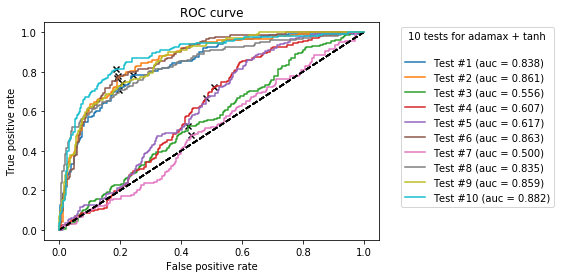

In [64]:
list_accuracy = list()
list_average_precision = list()
list_recall = list()
list_f1 = list()
for step in range(n_models):
    
    x_local_train, x_local_test, y_local_train, y_local_test = train_test_split(local_fluxes, local_labels, test_size=test_percent, random_state=step)
    x_global_train, x_global_test, y_global_train, y_global_test = train_test_split(global_fluxes, global_labels, test_size=test_percent, random_state=step)

    x_local_extended_test = np.expand_dims(x_local_test,axis=-1)
    y_local_extended_test = np.array(y_local_test)
    x_global_extended_test = np.expand_dims(x_global_test,axis=-1)
    y_global_extended_test = np.array(y_global_test)

    y_pred_keras = models[step].predict([x_local_extended_test,x_global_extended_test])
    y_pred_keras_standard = (y_pred_keras >= 0.5).astype(np.int)
    
    accuracy = accuracy_score(y_local_extended_test, y_pred_keras_standard)
    average_precision = average_precision_score(y_local_extended_test, y_pred_keras_standard)
    recall = recall_score(y_local_extended_test, y_pred_keras_standard, average=None)
    f1 = f1_score(y_local_extended_test, y_pred_keras_standard)

    list_accuracy.append(accuracy)
    list_average_precision.append(average_precision)
    list_recall.append(recall)
    list_f1.append(f1)


    # Defino las métricas
    false_positives, true_positives, thresholds = roc_curve(y_local_extended_test, y_pred_keras)
    area_under_curve = auc(false_positives, true_positives)
    gmeans = np.sqrt(true_positives * (1-false_positives))

    # localiza el índice del mayor g-mean
    ix = np.argmax(gmeans)
    pintar_roc_curve(false_positives, true_positives, "Test", str(step+1))



avg_accuracy = np.mean(list_accuracy)
avg_average_precision = np.mean(list_average_precision)
avg_recall = np.mean(list_recall)
avg_f1 = np.mean(list_f1)

print("list_accuracy: \t", list_accuracy);
print("avg_accuracy: \t", avg_accuracy);
print("\n\n");

print("list_average_precision: \t", list_average_precision);
print("avg_average_precision: \t", avg_average_precision);
print("\n\n");

print("list_recall: \t", list_recall);
print("avg_recall: \t", avg_recall);
print("\n\n");

print("list_f1: \t", list_f1);
print("avg_f1: \t", avg_f1);
print("\n\n");
